In [1]:
dnn_to_test = 50

In [2]:
from models.vae import VAE
from models.rnn import RNN
from models.dnn import DNN


import torch
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import re
import os
import numpy as np
from tqdm import tqdm
from scipy.io import loadmat
import matplotlib.pyplot as plt
from collections import defaultdict
from pandas import DataFrame, concat

In [3]:
seed = 13
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Path to all dataset
DATASET_PATH = os.path.join(os.getcwd(), 'data')
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.path.join(os.getcwd(), 'checkpoints')

# **DNN Data Generation**

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
Z, RES = defaultdict(dict), defaultdict(dict)
for severity in tqdm(range(5,10), desc='Reading data ... '):
    ATTACK_DATA_PATH = os.path.join(DATASET_PATH, f'I{severity}')
    for filename in os.listdir(ATTACK_DATA_PATH):
        fname = os.path.join(ATTACK_DATA_PATH, filename)
        data = loadmat(fname)
        att_type = int(re.findall(r'\d+', filename)[0])
        Z[severity][att_type] = data['Z']
        RES[severity][att_type] = data['Res']

NORMAL_DATA_FILENAME = 'Normal2.mat'
data = loadmat(os.path.join(DATASET_PATH, NORMAL_DATA_FILENAME))
Z[0] = data['Z']
RES[0] = data['Res']


Z = dict(sorted(Z.items()))
RES = dict(sorted(RES.items()))

Reading data ... : 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


In [7]:
latent_dim = 118
hidden_size = 100
num_layers = 2
rnn_window = 10
samples = 30

## **Load trained Models**

In [8]:
noise_levels = [0, 5, 10, 20, 50]
vaes, rnns = dict(), dict()
for level in noise_levels:
    vae = VAE(latent_dim).to(device)
    vae.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'vae_{level}%.pt')))
    vaes[level] = vae

    rnn = RNN(input_dims=rnn_window * latent_dim,
              outputdims=latent_dim,
              hidden_size=hidden_size,
              num_layers=num_layers).to(device)
    rnn.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'rnn_{level}%.pt')))
    rnns[level] = rnn

dnn = DNN().to(device)
dnn.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'dnn_{dnn_to_test}%.pt')))

<All keys matched successfully>

## **Normal Sensor Data To DNN Data**

In [9]:
pred_normal = defaultdict()
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    vae = vaes[level].eval()
    rnn = rnns[level].eval()
    # state estimation residual for normal data
    r1 = torch.tensor(RES[0], dtype=torch.float32)
    z = torch.tensor(Z[0], dtype=torch.float32).to(device)
    R = []
    for _ in range(samples):
        # VAE residuals for normal data
        z_rec = vae(z)
        r2 = (z_rec - z).detach().cpu()

        # rnn prediction residual
        s_t = vae.encoder(z)
        s_t = series_to_supervised(s_t.cpu().detach().numpy(), n_in=rnn_window).values[:,:rnn_window * latent_dim]
        s_t = torch.tensor(s_t, dtype=torch.float32).to(device)
        z_rnn = vae.decoder(rnn(s_t))
        r3 = (z_rnn - z[rnn_window:]).detach().cpu()
        R.append(torch.stack([r1[rnn_window:],r2[rnn_window:],r3], dim=1))
    pred_normal[level] = dnn(torch.stack(R, dim=1).to(device)).detach().cpu()

 Generating residuals ... : 100%|██████████| 5/5 [00:21<00:00,  4.26s/it]


## **Attack Sensor Data To DNN Data**

In [10]:
pred = defaultdict()
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    vae = vaes[level].eval()
    rnn = rnns[level].eval()
    for severity in range(5,10):
        _Z, _RES = Z[severity], RES[severity]
        R = defaultdict(list)
        for k, v in _Z.items():
            # state estimation residual
            r1 = torch.tensor(_RES[k], dtype=torch.float32)
            z = torch.tensor(v, dtype=torch.float32).to(device)
            _R = []
            for _ in range(samples):
                # VAE residuals
                z_rec = vae(z)
                r2 = (z_rec - z).detach().cpu()
                
                # rnn prediction residual
                s_t = vae.encoder(z)
                s_t = series_to_supervised(s_t.cpu().detach().numpy(), n_in=rnn_window).values[:,:rnn_window * latent_dim]
                s_t = torch.tensor(s_t, dtype=torch.float32).to(device)
                z_rnn = vae.decoder(rnn(s_t))
                r3 = (z_rnn - z[rnn_window:]).detach().cpu()
                _R.append(torch.stack([r1[rnn_window:],r2[rnn_window:],r3], dim=1))
            R[k] = torch.stack(_R, dim=1)
        R = dict(sorted(R.items()))
        _pred = dnn(torch.cat(list(R.values()), dim=0).to(device))
        pred[level,severity] = torch.cat([pred_normal[level].cpu(), _pred.cpu()], dim=0).detach()

 Generating residuals ... : 100%|██████████| 5/5 [05:22<00:00, 64.50s/it]


In [11]:
y = []
no_signal = len(Z[0]) - rnn_window
for l in range(4):
    y.append(F.one_hot(l * torch.ones((no_signal), dtype=torch.long), num_classes=4))
y = torch.cat(y, dim=0)

# **DNN Evaluation**

## **Confusion Matrices**

### **Confusion Matrix: Noise Level 0%**

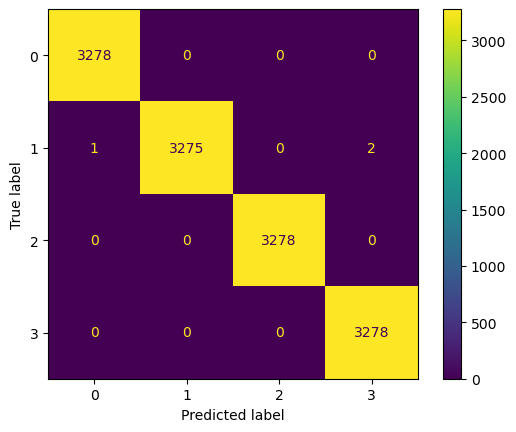

In [12]:
# severity 5
pp = torch.argmax(pred[0,5], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

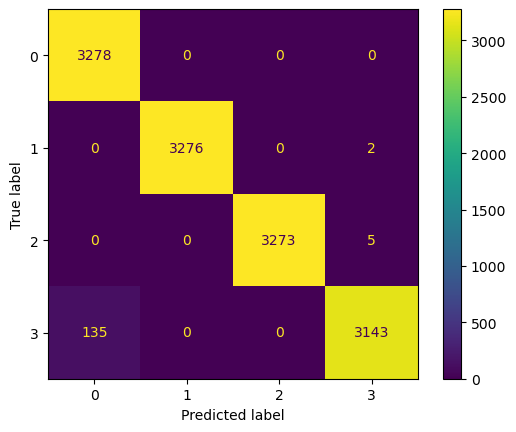

In [13]:
# severity 6
pp = torch.argmax(pred[0,6], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

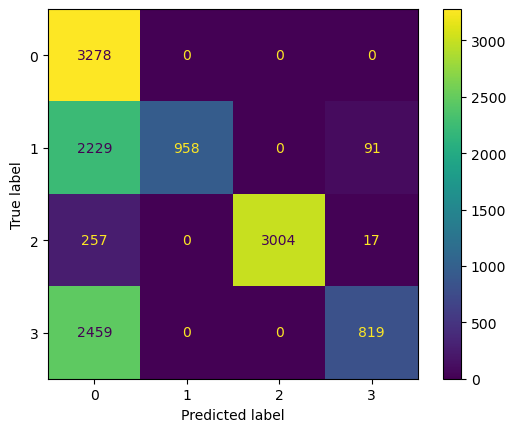

In [14]:
# severity 7
pp = torch.argmax(pred[0,7], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

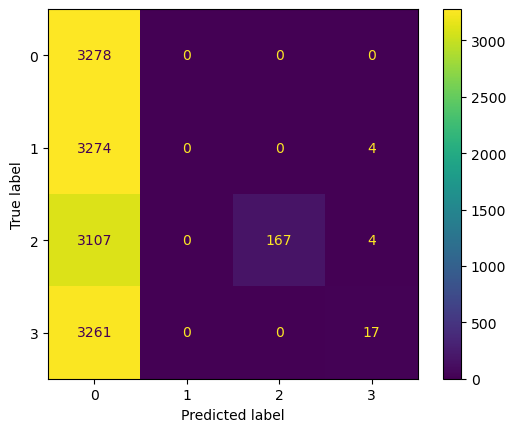

In [15]:
# severity 8
pp = torch.argmax(pred[0,8], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

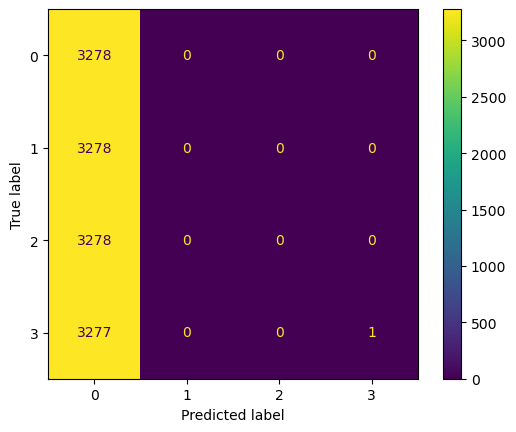

In [16]:
# severity 9
pp = torch.argmax(pred[0,9], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

### **Confusion Matrix: Noise Level 5%**

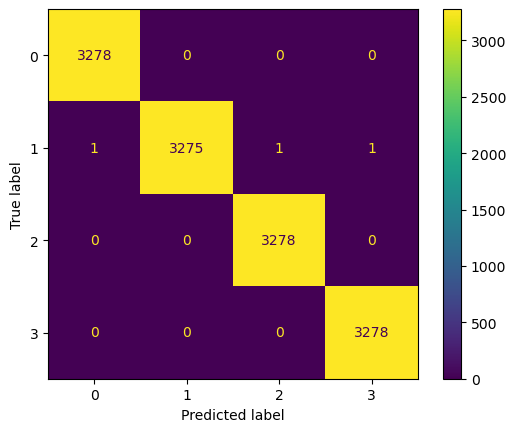

In [17]:
# severity 5
pp = torch.argmax(pred[5,5], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

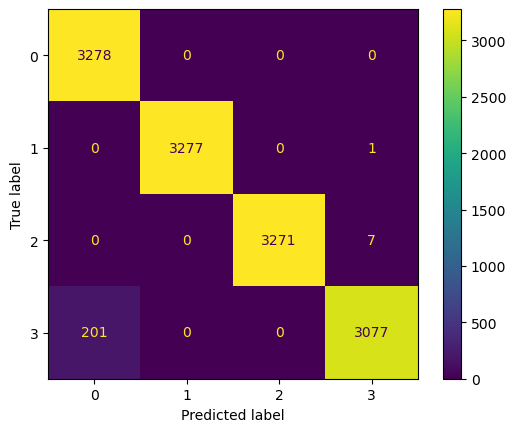

In [18]:
# severity 6
pp = torch.argmax(pred[5,6], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

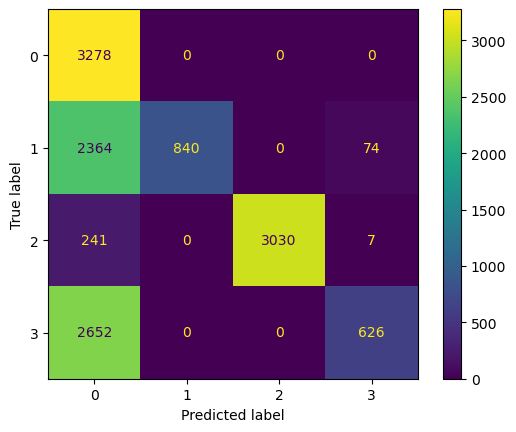

In [19]:
# severity 7
pp = torch.argmax(pred[5,7], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

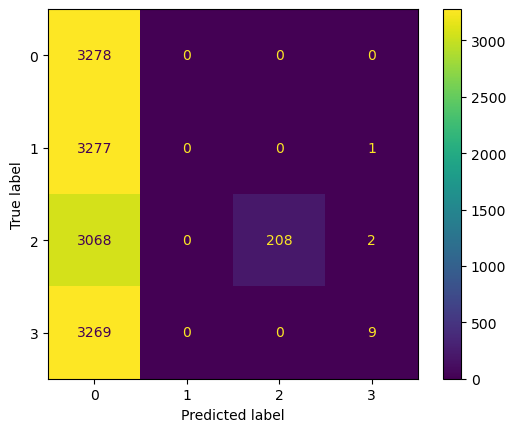

In [20]:
# severity 8
pp = torch.argmax(pred[5,8], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

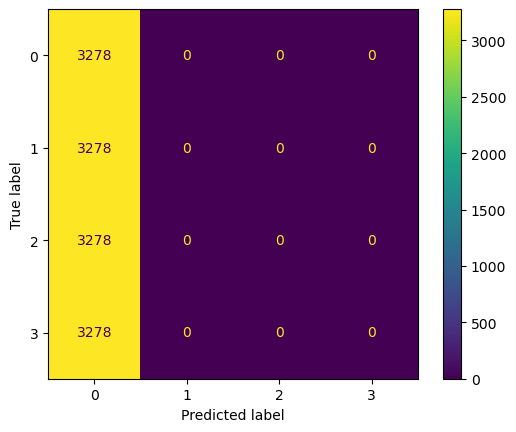

In [21]:
# severity 9
pp = torch.argmax(pred[5,9], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

### **Confusion Matrix: Noise Level 10%**

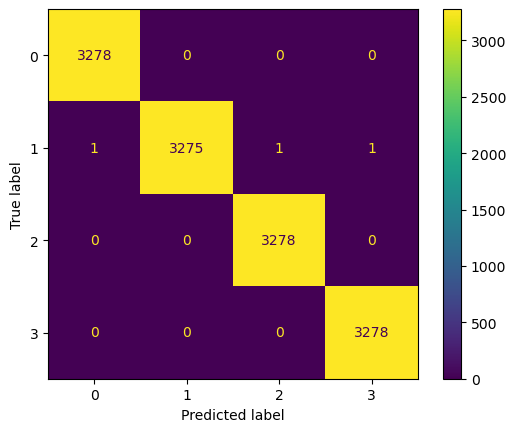

In [22]:
# severity 5
pp = torch.argmax(pred[10,5], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

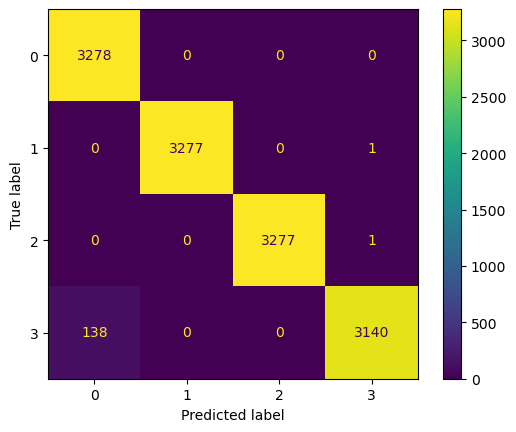

In [23]:
# severity 6
pp = torch.argmax(pred[10,6], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

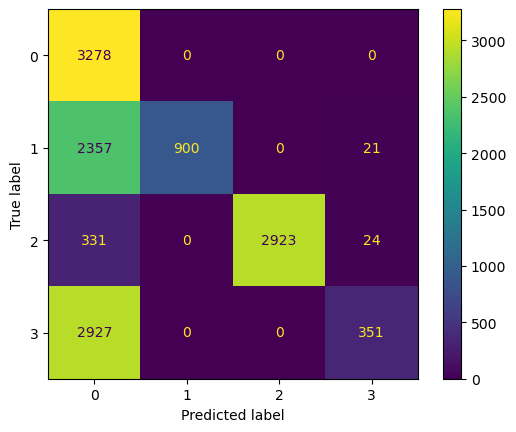

In [24]:
# severity 7
pp = torch.argmax(pred[10,7], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

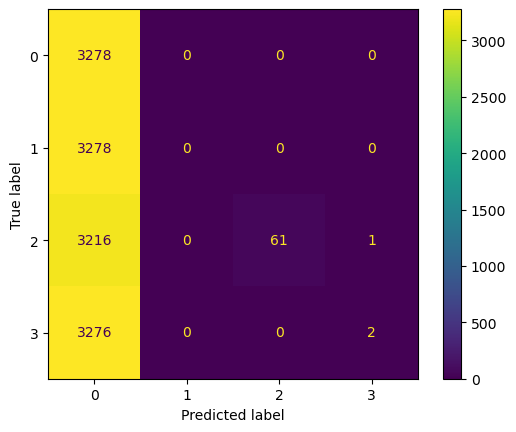

In [25]:
# severity 8
pp = torch.argmax(pred[10,8], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

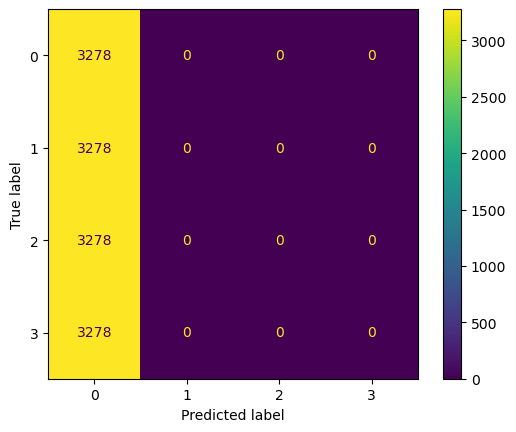

In [26]:
# severity 9
pp = torch.argmax(pred[10,9], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

### **Confusion Matrix: Noise Level 20%**

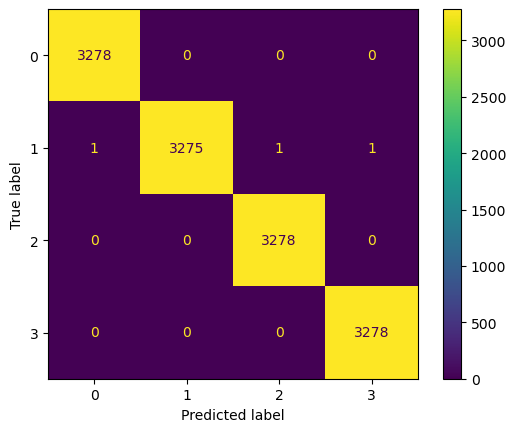

In [27]:
# severity 5
pp = torch.argmax(pred[20,5], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

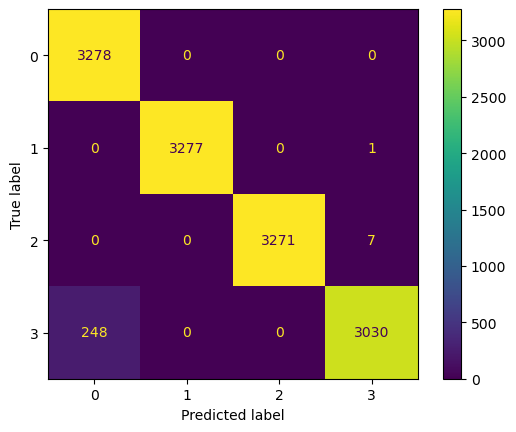

In [28]:
# severity 6
pp = torch.argmax(pred[20,6], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

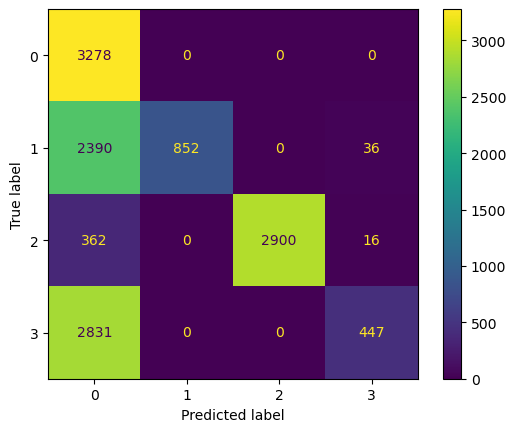

In [29]:
# severity 7
pp = torch.argmax(pred[20,7], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

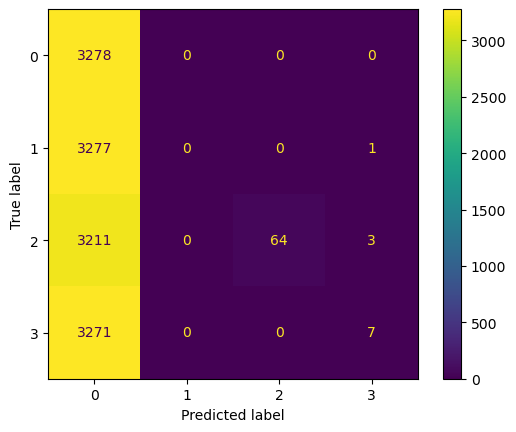

In [30]:
# severity 8
pp = torch.argmax(pred[20,8], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

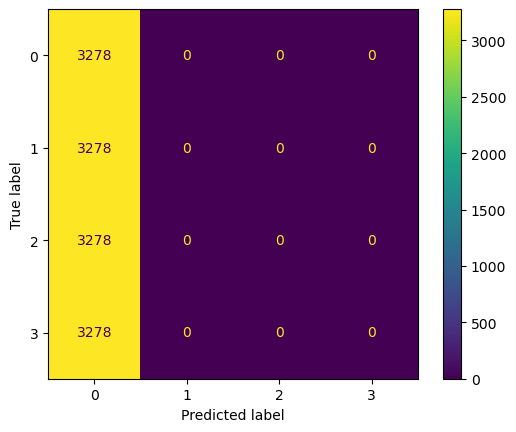

In [31]:
# severity 9
pp = torch.argmax(pred[20,9], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

### **Confusion Matrix: Noise Level 50%**

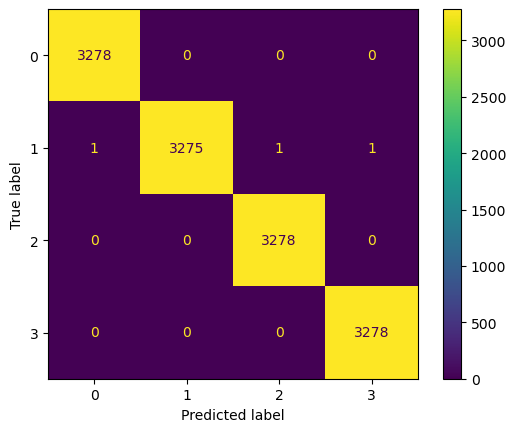

In [32]:
# severity 5
pp = torch.argmax(pred[50,5], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

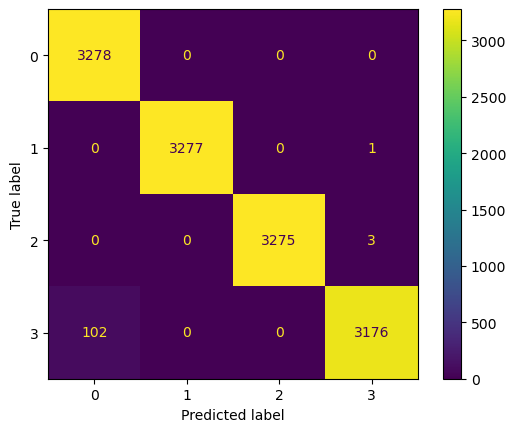

In [33]:
# severity 6
pp = torch.argmax(pred[50,6], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

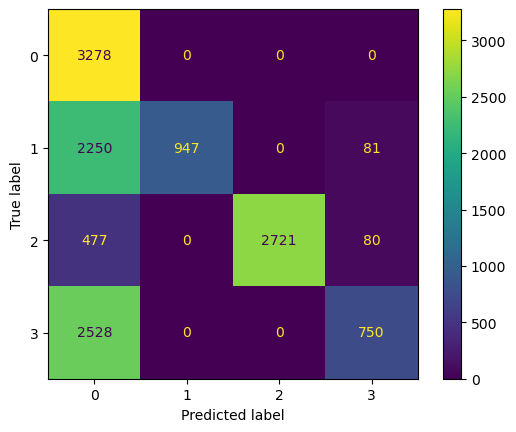

In [34]:
# severity 7
pp = torch.argmax(pred[50,7], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

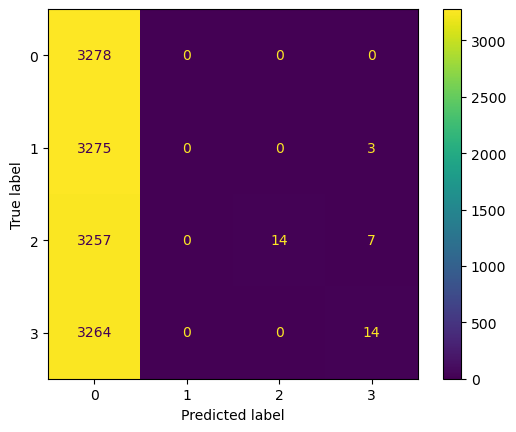

In [35]:
# severity 8
pp = torch.argmax(pred[50,8], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

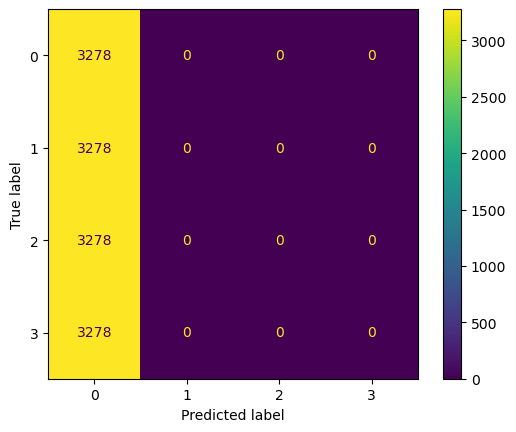

In [36]:
# severity 9
pp = torch.argmax(pred[50,9], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

## **Quantiles**

In [37]:
q = torch.tensor([0.025, 0.975])
x_ax = ['0%', '%5', '%10', '%20', '50%']

### **Quantiles: Attack Severity 5**

In [38]:
severity = 5
mean, low, up = defaultdict(), defaultdict(), defaultdict()
_min = defaultdict()
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    if k[1] == severity:
        for _type in range(4):
            _pred = v[_type * no_signal:(_type + 1) * no_signal]
            _min_val, _min_id = _pred.min(dim=0)
            _min[k[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
            mean[k[0],_type] = _pred.mean(dim=0).numpy()[_type]
            _low, _up = torch.quantile(_pred, q, dim=0).numpy()
            low[k[0], _type], up[k[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 25/25 [00:00<00:00, 586.37it/s]


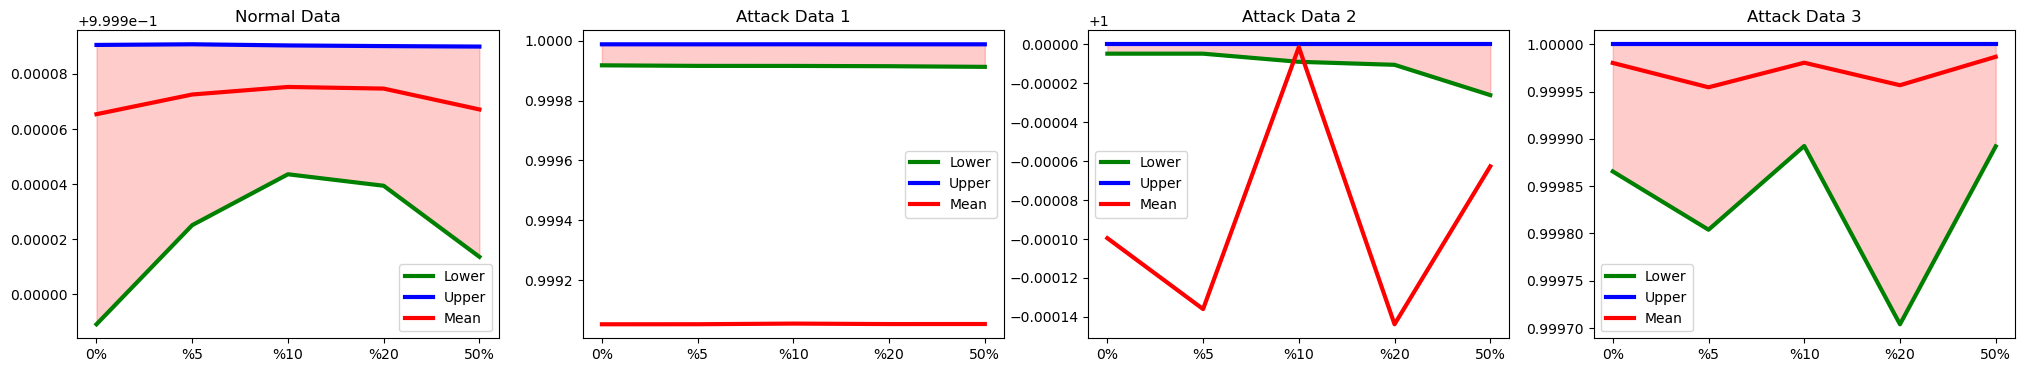

In [39]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(1, 4, figsize=(25, 4))
for _type in range(4):
    _m = [mean[l, _type] for l in noise_levels]
    _l = [low[l, _type] for l in noise_levels]
    _u = [up[l, _type] for l in noise_levels]
    ax[_type].plot(x, _l, label='Lower', lw=3, color='g')
    ax[_type].plot(x, _u, label='Upper', lw=3, color='b')
    ax[_type].plot(x, _m, label='Mean', lw=3, color='r')
    ax[_type].fill_between(x, _l, _u, color='r', alpha=0.2)
    ax[_type].set(xticks=x, xticklabels=x_ax)
    if _type == 0:
        ax[_type].title.set_text('Normal Data')
    else:
        ax[_type].title.set_text(f'Attack Data {_type}')
    ax[_type].legend()
plt.show()

### **Quantiles: Attack Severity 6**

In [40]:
severity = 6
mean, low, up = defaultdict(), defaultdict(), defaultdict()
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    if k[1] == severity:
        for _type in range(4):
            _pred = v[_type * no_signal:(_type + 1) * no_signal]
            mean[k[0],_type] = _pred.mean(dim=0).numpy()[_type]
            _low, _up = torch.quantile(_pred, q, dim=0).numpy()
            low[k[0], _type], up[k[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 25/25 [00:00<00:00, 1147.09it/s]


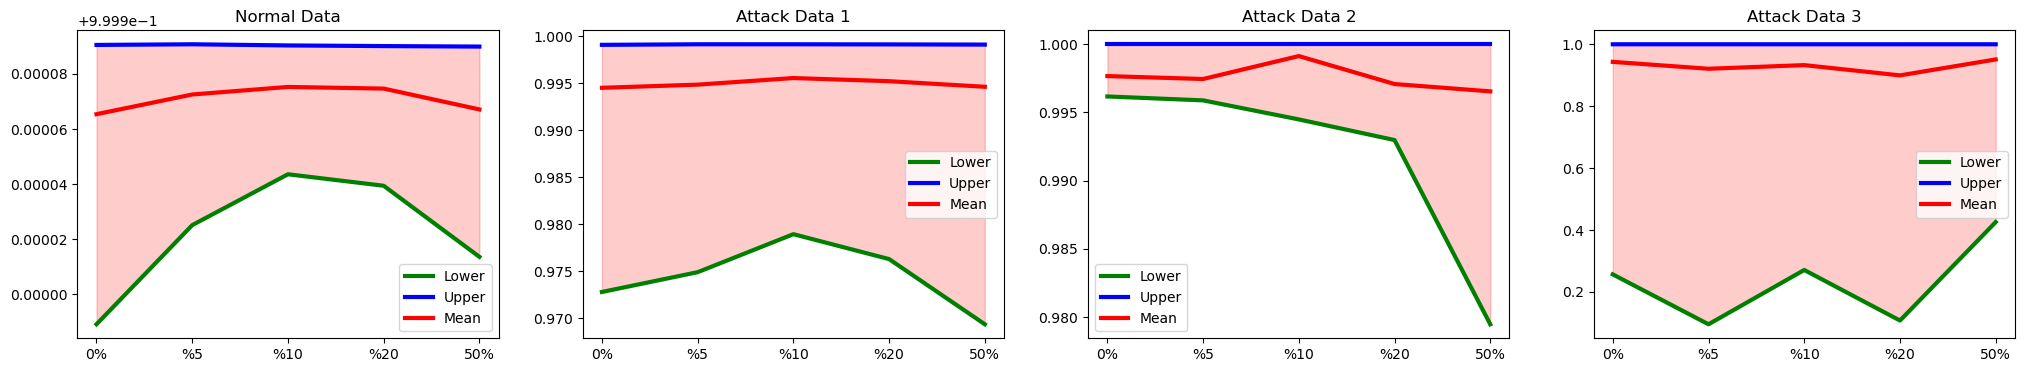

In [41]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(1, 4, figsize=(25, 4))
for _type in range(4):
    _m = [mean[l, _type] for l in noise_levels]
    _l = [low[l, _type] for l in noise_levels]
    _u = [up[l, _type] for l in noise_levels]
    ax[_type].plot(x, _l, label='Lower', lw=3, color='g')
    ax[_type].plot(x, _u, label='Upper', lw=3, color='b')
    ax[_type].plot(x, _m, label='Mean', lw=3, color='r')
    ax[_type].fill_between(x, _l, _u, color='r', alpha=0.2)
    ax[_type].set(xticks=x, xticklabels=x_ax)
    if _type == 0:
        ax[_type].title.set_text('Normal Data')
    else:
        ax[_type].title.set_text(f'Attack Data {_type}')
    ax[_type].legend()
plt.show()

### **Quantiles: Attack Severity 7**

In [42]:
severity = 7
mean, low, up = defaultdict(), defaultdict(), defaultdict()
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    if k[1] == severity:
        for _type in range(4):
            _pred = v[_type * no_signal:(_type + 1) * no_signal]
            mean[k[0],_type] = _pred.mean(dim=0).numpy()[_type]
            _low, _up = torch.quantile(_pred, q, dim=0).numpy()
            low[k[0], _type], up[k[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 25/25 [00:00<00:00, 1143.02it/s]


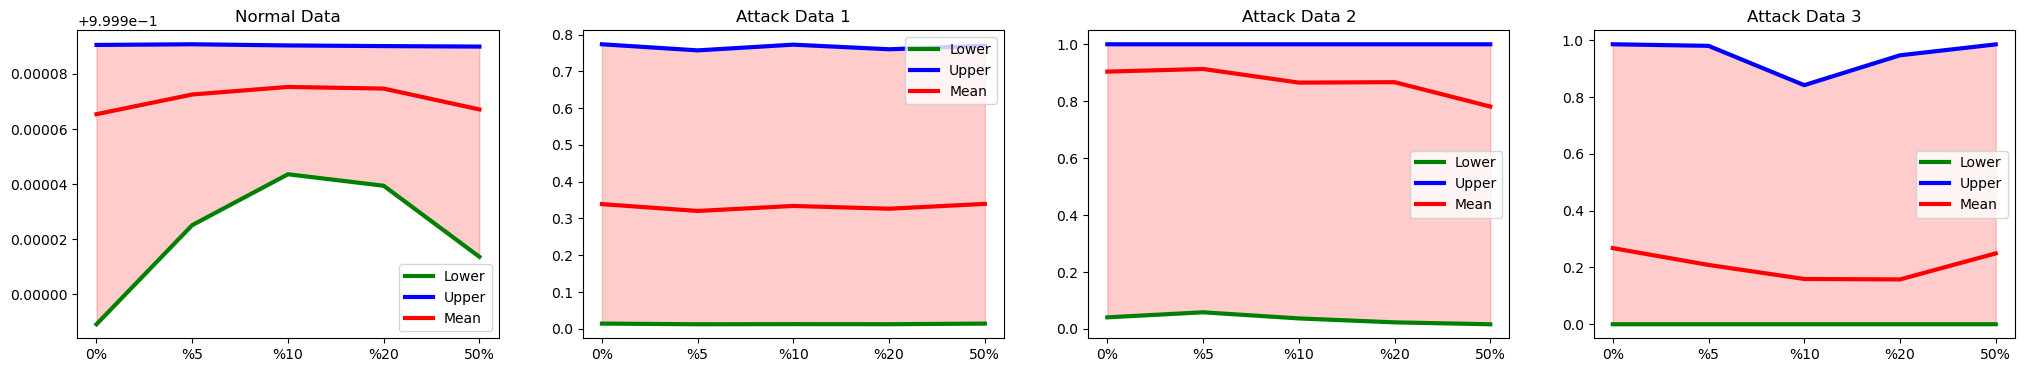

In [43]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(1, 4, figsize=(25, 4))
for _type in range(4):
    _m = [mean[l, _type] for l in noise_levels]
    _l = [low[l, _type] for l in noise_levels]
    _u = [up[l, _type] for l in noise_levels]
    ax[_type].plot(x, _l, label='Lower', lw=3, color='g')
    ax[_type].plot(x, _u, label='Upper', lw=3, color='b')
    ax[_type].plot(x, _m, label='Mean', lw=3, color='r')
    ax[_type].fill_between(x, _l, _u, color='r', alpha=0.2)
    ax[_type].set(xticks=x, xticklabels=x_ax)
    if _type == 0:
        ax[_type].title.set_text('Normal Data')
    else:
        ax[_type].title.set_text(f'Attack Data {_type}')
    ax[_type].legend()
plt.show()

### **Quantiles: Attack Severity 8**

In [44]:
severity = 8
mean, low, up = defaultdict(), defaultdict(), defaultdict()
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    if k[1] == severity:
        for _type in range(4):
            _pred = v[_type * no_signal:(_type + 1) * no_signal]
            mean[k[0],_type] = _pred.mean(dim=0).numpy()[_type]
            _low, _up = torch.quantile(_pred, q, dim=0).numpy()
            low[k[0], _type], up[k[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 25/25 [00:00<00:00, 1049.24it/s]


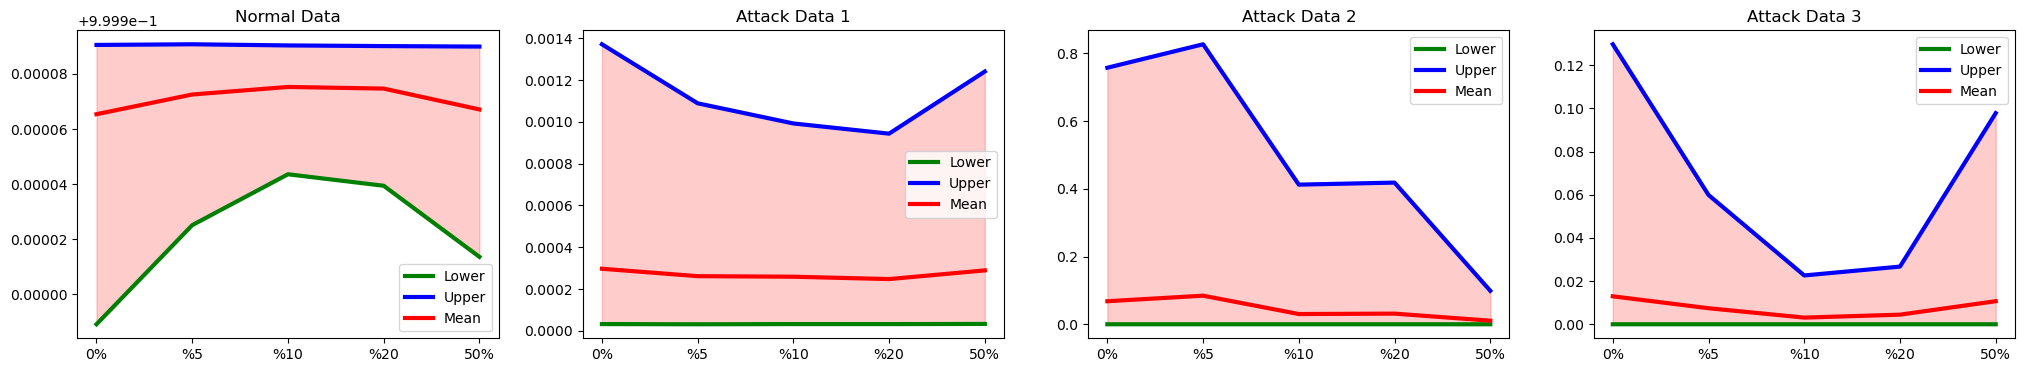

In [45]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(1, 4, figsize=(25, 4))
for _type in range(4):
    _m = [mean[l, _type] for l in noise_levels]
    _l = [low[l, _type] for l in noise_levels]
    _u = [up[l, _type] for l in noise_levels]
    ax[_type].plot(x, _l, label='Lower', lw=3, color='g')
    ax[_type].plot(x, _u, label='Upper', lw=3, color='b')
    ax[_type].plot(x, _m, label='Mean', lw=3, color='r')
    ax[_type].fill_between(x, _l, _u, color='r', alpha=0.2)
    ax[_type].set(xticks=x, xticklabels=x_ax)
    if _type == 0:
        ax[_type].title.set_text('Normal Data')
    else:
        ax[_type].title.set_text(f'Attack Data {_type}')
    ax[_type].legend()
plt.show()

### **Quantiles: Attack Severity 9**

In [46]:
severity = 9
mean, low, up = defaultdict(), defaultdict(), defaultdict()
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    if k[1] == severity:
        for _type in range(4):
            _pred = v[_type * no_signal:(_type + 1) * no_signal]
            mean[k[0],_type] = _pred.mean(dim=0).numpy()[_type]
            _low, _up = torch.quantile(_pred, q, dim=0).numpy()
            low[k[0], _type], up[k[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 25/25 [00:00<00:00, 1100.15it/s]


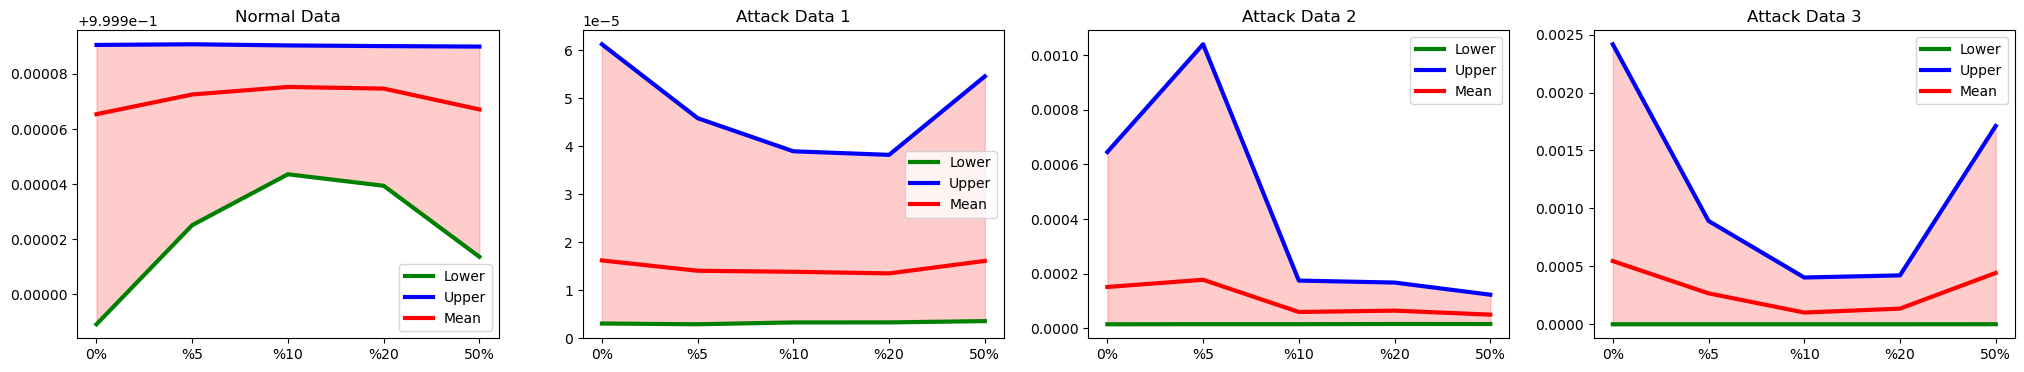

In [47]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(1, 4, figsize=(25, 4))
for _type in range(4):
    _m = [mean[l, _type] for l in noise_levels]
    _l = [low[l, _type] for l in noise_levels]
    _u = [up[l, _type] for l in noise_levels]
    ax[_type].plot(x, _l, label='Lower', lw=3, color='g')
    ax[_type].plot(x, _u, label='Upper', lw=3, color='b')
    ax[_type].plot(x, _m, label='Mean', lw=3, color='r')
    ax[_type].fill_between(x, _l, _u, color='r', alpha=0.2)
    ax[_type].set(xticks=x, xticklabels=x_ax)
    if _type == 0:
        ax[_type].title.set_text('Normal Data')
    else:
        ax[_type].title.set_text(f'Attack Data {_type}')
    ax[_type].legend()
plt.show()